#Classification using ResNet18

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# SETUP (run after mounting Drive)
!pip install -q albumentations timm pyarrow
PROJECT_DIR = r"/content/drive/MyDrive/rsna_classification"
META_DIR = r"/content/drive/MyDrive/rsna_classification/meta/meta"
DATA_DIR = r"/content/drive/MyDrive/rsna_classification/train_jpg/train_jpg"
print('PROJECT_DIR:', PROJECT_DIR)
print('META_DIR   :', META_DIR)
print('DATA_DIR   :', DATA_DIR)


PROJECT_DIR: /content/drive/MyDrive/rsna_classification
META_DIR   : /content/drive/MyDrive/rsna_classification/meta/meta
DATA_DIR   : /content/drive/MyDrive/rsna_classification/train_jpg/train_jpg


In [8]:
# Load metadata and build filenames + label columns
import pandas as pd, os
candidates=['labels.fth','comb.fth','df_trn.fth','df_tst.fth']
labels_path=None
for c in candidates:
    p=os.path.join(META_DIR,c)
    if os.path.exists(p):
        labels_path=p
        break
if labels_path is None:
    raise FileNotFoundError('No metadata file found in META_DIR: ' + str(META_DIR))
print('Using meta file:', labels_path)
df = pd.read_feather(labels_path)
print('Original meta rows:', len(df))
if 'ID' in df.columns:
    df['filename'] = df['ID'].astype(str) + '.jpg'
    LABEL_COLS = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
else:
    if 'fname' in df.columns:
        df['filename'] = df['fname'].apply(lambda x: os.path.basename(x))
    LABEL_COLS = [c for c in ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'] if c in df.columns]
print('Label columns:', LABEL_COLS)
# keep only rows that have an actual image in DATA_DIR
existing = set([f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))])
print('Found images in DATA_DIR:', len(existing))
old = len(df)
df = df[df['filename'].isin(existing)].reset_index(drop=True)
print('Cleaned df rows:', len(df), 'removed:', old - len(df))
# save cleaned metadata for future use
clean_path = os.path.join(META_DIR, 'labels_cleaned.fth')
df.to_feather(clean_path)
print('Saved cleaned metadata to:', clean_path)
# show sample
print(df.head())


Using meta file: /content/drive/MyDrive/rsna_classification/meta/meta/labels.fth
Original meta rows: 674258
Label columns: ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
Found images in DATA_DIR: 78257
Cleaned df rows: 78257 removed: 596001
Saved cleaned metadata to: /content/drive/MyDrive/rsna_classification/meta/meta/labels_cleaned.fth
             ID  any  epidural  intraparenchymal  intraventricular  \
0  ID_00008ce3c    0         0                 0                 0   
1  ID_0000aee4b    0         0                 0                 0   
2  ID_0002003a8    0         0                 0                 0   
3  ID_0002081b6    1         0                 1                 0   
4  ID_00027cbb1    0         0                 0                 0   

   subarachnoid  subdural          filename  
0             0         0  ID_00008ce3c.jpg  
1             0         0  ID_0000aee4b.jpg  
2             0         0  ID_0002003a8.jpg  
3             

In [9]:
# Robust RSNADataset + DataLoader creation (safe defaults)
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

class RSNADataset(Dataset):
    def __init__(self, df, root, augment=False, max_attempts=8):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.augment = augment
        self.max_attempts = max_attempts
        self.bad_files_seen = []
        if augment:
            self.transforms = A.Compose([
                A.Resize(256,256), A.HorizontalFlip(p=0.5), A.Rotate(limit=10,p=0.5), A.RandomBrightnessContrast(p=0.2), ToTensorV2()])
        else:
            self.transforms = A.Compose([A.Resize(256,256), ToTensorV2()])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        attempts = 0
        while attempts < self.max_attempts:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.root, row['filename'])
            if not os.path.exists(img_path):
                self.bad_files_seen.append(row['filename'])
                idx = random.randint(0, len(self.df)-1)
                attempts += 1
                continue
            try:
                img = Image.open(img_path).convert('RGB')
            except Exception:
                self.bad_files_seen.append(row['filename'])
                idx = random.randint(0, len(self.df)-1)
                attempts += 1
                continue
            img = np.array(img)
            img = self.transforms(image=img)['image']
            labels = torch.tensor(row[LABEL_COLS].values.astype('float32'))
            return img, labels
        raise RuntimeError(f'Failed to load a valid image after {self.max_attempts} attempts. Bad seen: {self.bad_files_seen[:10]}')

# Create train/val split and loaders (num_workers=0 for safe debugging)
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['any'])
train_ds = RSNADataset(train_df, DATA_DIR, augment=True)
val_ds   = RSNADataset(val_df, DATA_DIR, augment=False)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
print('Train size:', len(train_ds), 'Val size:', len(val_ds))


Train size: 66518 Val size: 11739


In [10]:
# Sanity check: fetch one batch (should succeed)
batch = next(iter(train_loader))
imgs, labels = batch
print('Batch shapes:', imgs.shape, labels.shape)


Batch shapes: torch.Size([32, 3, 256, 256]) torch.Size([32, 6])


In [11]:
# Model setup (ResNet18)
import timm, torch.nn as nn, torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
model = timm.create_model('resnet18', pretrained=True, num_classes=len(LABEL_COLS))
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [12]:
# ----- Replacement cell: normalized dataset + loaders + training/validation funcs -----
import os, random, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Ensure device variable exists
try:
    device
except NameError:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Normalized, robust dataset (non-recursive)
class NormalizedRSNADataset(Dataset):
    def __init__(self, df, root, augment=False, max_attempts=8):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.augment = augment
        self.max_attempts = max_attempts
        self.bad_files_seen = []

        # Use ImageNet normalization because we're using pretrained backbones
        if augment:
            self.transforms = A.Compose([
                A.Resize(256, 256),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=10, p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                A.Resize(256, 256),
                A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < self.max_attempts:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.root, row['filename'])

            # quick existence check
            if not os.path.exists(img_path):
                self.bad_files_seen.append(row['filename'])
                idx = random.randint(0, len(self.df)-1)
                attempts += 1
                continue

            # attempt open
            try:
                img = Image.open(img_path).convert('RGB')
            except Exception:
                self.bad_files_seen.append(row['filename'])
                idx = random.randint(0, len(self.df)-1)
                attempts += 1
                continue

            img = np.array(img)
            img = self.transforms(image=img)['image']   # This will be float32 tensor
            labels = torch.tensor(row[LABEL_COLS].values.astype('float32'))
            return img, labels

        # If we reach here, loading failed repeatedly
        raise RuntimeError(f"Failed to load a valid image after {self.max_attempts} attempts. Bad seen: {self.bad_files_seen[:16]}")

# Recreate train/val datasets & DataLoaders (uses existing train_df/val_df if present)
try:
    train_df, val_df
except NameError:
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['any'])

train_ds = NormalizedRSNADataset(train_df, DATA_DIR, augment=True)
val_ds   = NormalizedRSNADataset(val_df, DATA_DIR, augment=False)

# Use small batch for safety; change batch_size as needed if OOM
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print("Train size:", len(train_ds), "Val size:", len(val_ds))

# Quick sanity check: fetch one batch
batch = next(iter(train_loader))
imgs, labels = batch
print("Sanity batch - imgs dtype:", imgs.dtype, "shape:", imgs.shape)
print("Sanity batch - labels dtype:", labels.dtype, "shape:", labels.shape)

# ---- Re-define training / validation functions that cast inputs to float and move to device ----
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for imgs, labels in loader:
        imgs = imgs.float().to(device)        # ensure float32 on correct device
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

print("Replacement cell loaded: dataset, loaders, and train/validate functions are ready.")


Using device: cuda
Train size: 66518 Val size: 11739
Sanity batch - imgs dtype: torch.float32 shape: torch.Size([32, 3, 256, 256])
Sanity batch - labels dtype: torch.float32 shape: torch.Size([32, 6])
Replacement cell loaded: dataset, loaders, and train/validate functions are ready.


In [13]:
# ---- Replacement inference cell (uses same Normalize as training) ----
from albumentations.pytorch import ToTensorV2
import albumentations as A
import numpy as np
from PIL import Image
import torch

model.eval()

# same transforms used during training
inference_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

rows = val_df.sample(5).reset_index(drop=True)
for _, row in rows.iterrows():
    p = os.path.join(DATA_DIR, row['filename'])
    try:
        img = Image.open(p).convert('RGB')
    except Exception:
        print('Skipping unreadable:', row['filename'])
        continue

    # apply same preprocessing as training -> returns float32 tensor
    img_t = inference_transform(image=np.array(img))['image'].unsqueeze(0).to(device)
    # defensive cast to float32 (harmless if already float)
    img_t = img_t.float()

    with torch.no_grad():
        out = model(img_t)
        probs = torch.sigmoid(out).cpu().numpy()[0]
    print('File:', row['filename'], 'Probs:', np.round(probs, 3))


File: ID_63e072964.jpg Probs: [0.421 0.485 0.476 0.516 0.478 0.567]
File: ID_1ddc834d3.jpg Probs: [0.455 0.494 0.488 0.477 0.505 0.54 ]
File: ID_043afd519.jpg Probs: [0.393 0.45  0.495 0.432 0.495 0.604]
File: ID_19663df6f.jpg Probs: [0.394 0.493 0.456 0.502 0.531 0.575]
File: ID_11821f91f.jpg Probs: [0.406 0.478 0.475 0.437 0.494 0.577]


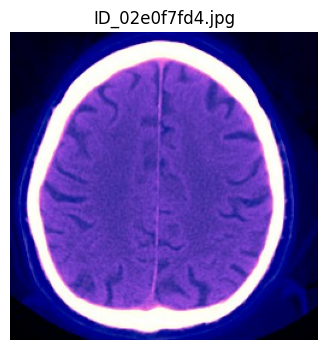

Ground Truth:
  any: 0
  epidural: 0
  intraparenchymal: 0
  intraventricular: 0
  subarachnoid: 0
  subdural: 0

Model Prediction (probabilities):
  any: 0.436
  epidural: 0.501
  intraparenchymal: 0.484
  intraventricular: 0.462
  subarachnoid: 0.495
  subdural: 0.557
----------------------------------------


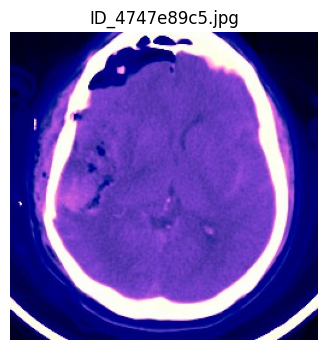

Ground Truth:
  any: 1
  epidural: 0
  intraparenchymal: 1
  intraventricular: 0
  subarachnoid: 1
  subdural: 1

Model Prediction (probabilities):
  any: 0.435
  epidural: 0.501
  intraparenchymal: 0.488
  intraventricular: 0.480
  subarachnoid: 0.500
  subdural: 0.581
----------------------------------------


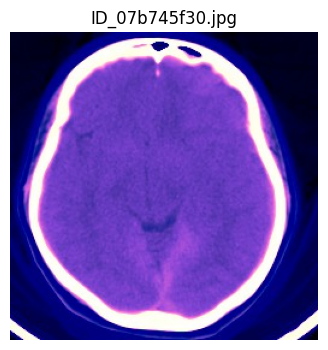

Ground Truth:
  any: 1
  epidural: 0
  intraparenchymal: 0
  intraventricular: 0
  subarachnoid: 0
  subdural: 1

Model Prediction (probabilities):
  any: 0.404
  epidural: 0.503
  intraparenchymal: 0.497
  intraventricular: 0.455
  subarachnoid: 0.521
  subdural: 0.578
----------------------------------------


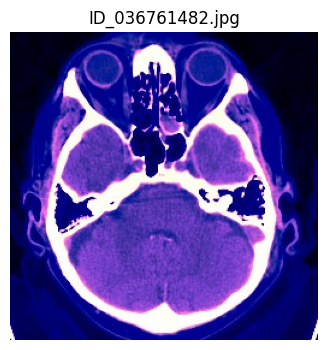

Ground Truth:
  any: 1
  epidural: 0
  intraparenchymal: 0
  intraventricular: 0
  subarachnoid: 1
  subdural: 1

Model Prediction (probabilities):
  any: 0.399
  epidural: 0.491
  intraparenchymal: 0.466
  intraventricular: 0.500
  subarachnoid: 0.528
  subdural: 0.578
----------------------------------------


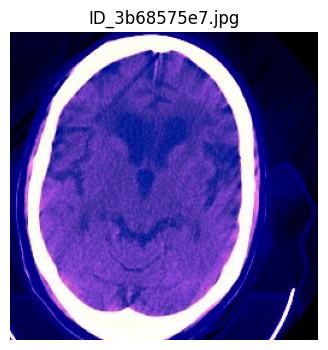

Ground Truth:
  any: 0
  epidural: 0
  intraparenchymal: 0
  intraventricular: 0
  subarachnoid: 0
  subdural: 0

Model Prediction (probabilities):
  any: 0.411
  epidural: 0.490
  intraparenchymal: 0.481
  intraventricular: 0.466
  subarachnoid: 0.498
  subdural: 0.550
----------------------------------------


In [14]:
# ---------- DEMO OUTPUT CELL (FOR PANEL / VIVA) ----------
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# pick 5 validation samples (mix of positive & negative)
samples = val_df.sample(5, random_state=42).reset_index(drop=True)

for _, row in samples.iterrows():
    img_path = os.path.join(DATA_DIR, row['filename'])
    try:
        img = Image.open(img_path).convert("RGB")
    except:
        continue

    img_arr = np.array(img)
    img_t = inference_transform(image=img_arr)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_t)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # display image
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(row['filename'])
    plt.show()

    print("Ground Truth:")
    for c in LABEL_COLS:
        print(f"  {c}: {int(row[c])}")

    print("\nModel Prediction (probabilities):")
    for c, p in zip(LABEL_COLS, probs):
        print(f"  {c}: {p:.3f}")

    print("-" * 40)
